In [3]:
class bcolors:
    OK = '\033[92m' #GREEN
    WARNING = '\033[93m' #YELLOW
    FAIL = '\033[91m' #RED
    RESET = '\033[0m' #RESET COLOR

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from pandas.core.common import flatten
import random
import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2

from GPUtil import showUtilization as gpu_usage
from numba import cuda

print(f'{bcolors.OK}Enviroment setup complete!{bcolors.RESET}')

Enviroment setup complete!


In [5]:
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  2% |  7% |
|  1 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  4% |  8% |
|  1 |  0% |  0% |


In [6]:
class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

In [7]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': A.Compose([A.Resize(600 , 600), A.Normalize(mean, std), ToTensorV2()]),
    'test': A.Compose([A.Resize(600 , 600), A.Normalize(mean, std), ToTensorV2()])
}

In [8]:
data_dir = 'D:\sl\images'
sets = ['train', 'test']

In [9]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform =Transforms(transforms=data_transforms[x])) for x in ['train', 'test']}

In [10]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'test']}

In [11]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('train: {} test: {}'.format(dataset_sizes['train'], dataset_sizes['test']))
print(class_names)

train: 20265 test: 5066
['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


In [12]:
inputs, classes = next(iter(dataloaders['train']))
print(inputs.size())

torch.Size([4, 3, 600, 600])


In [13]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)
print(f"Using {device} device")

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']
Using cuda:0 device


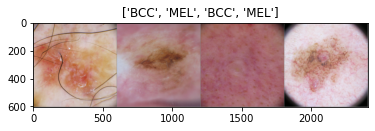

In [14]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [15]:
def train_model(model, cirterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epoch-1}')
    print('-' * 10)

    for phase in ['train', 'test']:
      if phase =='train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history only if train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = cirterion(outputs, labels)

          #backward + optimize only if in train
          if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m { time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [16]:
epoch, num_epoch = 2, 25
print(f'Epoch {epoch}/{num_epoch-1}')
print('-' * 10)

Epoch 2/24
----------


In [17]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

E:\conda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\conda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
model.fc = nn.Linear(num_ftrs, 8)
model = model.to(device)

In [19]:
criterion = nn.CrossEntropyLoss()

In [20]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [21]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [22]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1673, Acc: 0.5914
test Loss: 0.9490, Acc: 0.6644

Epoch 1/24
----------
train Loss: 1.0292, Acc: 0.6396
test Loss: 0.8836, Acc: 0.6871

Epoch 2/24
----------
train Loss: 0.9541, Acc: 0.6651
test Loss: 0.8018, Acc: 0.7120

Epoch 3/24
----------
train Loss: 0.8901, Acc: 0.6865
test Loss: 0.7965, Acc: 0.7138

Epoch 4/24
----------
train Loss: 0.8416, Acc: 0.7053
test Loss: 0.7773, Acc: 0.7254

Epoch 5/24
----------
train Loss: 0.7895, Acc: 0.7255
test Loss: 0.7354, Acc: 0.7386

Epoch 6/24
----------
train Loss: 0.7431, Acc: 0.7400
test Loss: 0.6972, Acc: 0.7615

Epoch 7/24
----------
train Loss: 0.6653, Acc: 0.7736
test Loss: 0.6899, Acc: 0.7600

Epoch 8/24
----------
train Loss: 0.6446, Acc: 0.7807
test Loss: 0.6935, Acc: 0.7584

Epoch 9/24
----------
train Loss: 0.6335, Acc: 0.7852
test Loss: 0.6790, Acc: 0.7594

Epoch 10/24
----------
train Loss: 0.6342, Acc: 0.7840
test Loss: 0.6803, Acc: 0.7641

Epoch 11/24
----------
train Loss: 0.6234, Acc: 0.789